In [1]:
from Helper_functions import Get_valid_chunk_sizes
from Helper_functions import Build_canonical_map
from Helper_functions import Get_seed

from pathlib import Path
from Bio import SeqIO
from collections import defaultdict
import joblib
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

In [2]:
    

# /////////
def get_interpolated_mean(x, mean_vec_interpolators):
    interpolated_mean_vec = np.array([spline(x) for spline in mean_vec_interpolators])
    return interpolated_mean_vec

def get_interpolated_cov(new_chunk_size, cov_interpolators):
    n_kmers = 136
    cov_matrix = np.zeros((n_kmers, n_kmers))

    for i in range(n_kmers):
        for j in range(n_kmers):
            cov_matrix[i, j] = cov_interpolators[i][j](new_chunk_size)
    # force symetry
    cov_matrix = (cov_matrix + cov_matrix.T) / 2
    return cov_matrix
# ////////////

def Get_interpolator_vecs(Interpolator_file, Chunk_sizes):
    Bundle = joblib.load(Interpolator_file)
    Interp_chunk_sizes = Bundle["Chunk_sizes"]

    Interp_dic = defaultdict(dict)

    for Chunk_size in Chunk_sizes:
        if Chunk_size not in Interp_chunk_sizes:
            continue  # skip invalid sizes entirely

        Mean_vec = get_interpolated_mean(Chunk_size, Bundle["Mean_counts_interpolator"])
        Cov_vec = get_interpolated_cov(Chunk_size, Bundle["Cov_interpolator"])

        Interp_dic[Chunk_size]["Mean_vec"] = Mean_vec
        Interp_dic[Chunk_size]["Cov_vec"] = Cov_vec 

    return Interp_dic


def Generate_interpolated(Interpolators_dir):

    Chunk_sizes = [100, 200, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000]
    
    Master_dic = defaultdict(dict)
    for Genome in Path(Interpolators_dir).iterdir():
        for Interpolator_file in Genome.iterdir():
            if ".ipynb_checkpoints" in Interpolator_file.name:
                continue 
            Interp_dic = Get_interpolator_vecs(Interpolator_file, Chunk_sizes) 
            Master_dic[Genome.name][Interpolator_file.stem] = Interp_dic
    return Master_dic

In [5]:

def log_likelihood(kmer_cols_sorted, Interpolator_file, chunk_size):
    Bundle = joblib.load(Interpolator_file)

    mean_vec_Interpolator = Bundle["mean_interpolator"]
    cov_vec_Interpolator = Bundle["cov_vec_interpolator"]

    # Interpolated vectors 
    mean_vec_chunksize = get_interpolated_mean(chunk_size, mean_vec_Interpolator)
    cov_vec_chunksize = get_interpolated_cov(chunk_size, cov_vec_Interpolator)

    
    mvn_dist = multivariate_normal(mean_vec_chunksize, cov_vec_chunksize, allow_singular = True)
    points = kmer_cols_sorted.to_numpy() # shape = (150, 136)
    print(points.shape)
    logpdf_values = mvn_dist.logpdf(points)

    return logpdf_values
    

import pandas as pd
from scipy.stats import multivariate_normal

def Calculate_distance(Master_interpolators, Counts_dic, Source_genome, Source_chromosome):
    results = []

    # Iterate over chunk sizes
    for Chunk_size, chunks in Counts_dic.items():
        num_chunks = chunks.shape[0]

        # Pre-build the row template for this set of chunks
        for chunk_idx in range(num_chunks):
            row = {
                "Source_genome": Source_genome,
                "Source_chromosome": Source_chromosome,
                "Chunk_size": Chunk_size,
                "Chunk_id": chunk_idx
            }

            # For each target genome/chromosome, compute distance for this chunk
            for Target_genome, Chromosome_subset in Master_interpolators.items():
                for Target_chromosome, Chunk_size_subset in Chromosome_subset.items():
                    for Interpolator_chunk_size, vectors in Chunk_size_subset.items():
                        if Chunk_size != Interpolator_chunk_size:
                            continue

                        mean_vec = vectors["Mean_vec"]
                        cov_vec = vectors["Cov_vec"]
                        mvn_dist = multivariate_normal(mean_vec, cov_vec, allow_singular=True)
                        logpdf_value = mvn_dist.logpdf(chunks[chunk_idx])

                        col_name = f"{Target_chromosome}|{Target_genome}"
                        row[col_name] = logpdf_value

            results.append(row)

    # Convert accumulated rows to DataFrame
    Genome_df = pd.DataFrame(results)
    return Genome_df

    

def Chunk_chromosome(Valid_chunk_sizes, Kmer_size, Canonical_map, Chromosome_seq, Chromosome_id, Num_chunks, Kmer_index):
    Counts_dic = {}

    for Chunk_size in Valid_chunk_sizes:
        Counted_chunks_array = np.zeros((Num_chunks, len(Kmer_index)), dtype="int64")

        Half_chunk_size = Chunk_size // 2
        for Chunk in range(Num_chunks):
            Seed_location = Get_seed(Chromosome_id, Half_chunk_size, Chunk, len(Chromosome_seq), Interpolator=False)
            Start = int(Seed_location - Half_chunk_size)
            Stop = int(Seed_location + Half_chunk_size - Kmer_size + 1)

            for Window in range(Start, Stop):
                Raw_kmer = Chromosome_seq[Window:(Window + Kmer_size)]
                Canonical_kmer = Canonical_map.get(Raw_kmer)
                col = Kmer_index[Canonical_kmer]
                Counted_chunks_array[Chunk, col] += 1

        Counts_dic[Chunk_size] = Counted_chunks_array

    return Counts_dic


def Master_binning(Genome_paths, Interpolators_dir, Kmer_size, Num_chunks):

    Final_output = []

    Master_interpolators = Generate_interpolated(Interpolators_dir)

    Canonical_map = Build_canonical_map(Kmer_size)
    All_kmers = sorted(set(Canonical_map.values()))
    Kmer_index = {kmer: idx for idx, kmer in enumerate(All_kmers)}

    Genome_paths = Path(Genome_paths)

    for Genome_file in Genome_paths.iterdir():
        if ".ipynb_checkpoints" in Genome_file.name:
            continue

        Genome_name_ext = Genome_file.name
        Genome_name = ".".join(Genome_name_ext.split(".")[:-1])

        for Chromosome in SeqIO.parse(Genome_file, "fasta"):
            Valid_chunk_sizes = Get_valid_chunk_sizes(len(Chromosome.seq))
            Counts_dic = Chunk_chromosome(Valid_chunk_sizes, Kmer_size, Canonical_map, Chromosome.seq, Chromosome.id, Num_chunks,Kmer_index)

        Genome_df = Calculate_distance(Master_interpolators, Counts_dic, Genome_name, Chromosome.id)
        Final_output.append(Genome_df)

    Final_df = pd.concat(Final_output)

    Final_df.to_csv("C:/users/henry chapman/Documents/Galaxy/Output/Pipe_2/Binned/Raw_counts/Binned.csv", index = False)
    


Master_binning("C:/users/henry chapman/Documents/Galaxy/Raw_data/Genomes", "C:/users/henry chapman/Documents/Galaxy/Output/Pipe_1/Interpolators/Kmer_size_4/Raw_counts", 4, 100)


In [14]:

import matplotlib.pyplot as plt

def Analyse(df):
    accuracy_data = []

    for Chunk_size, subset in df.groupby("Chunk_size"):
        subset_clean = subset.dropna(axis=1).copy()

        Prediction_cols = subset_clean.drop(["Chunk_size", "Chunk_id", "Source_genome", "Source_chromosome"], axis=1)

        subset_clean.loc[:, "Best_match"] = Prediction_cols.idxmax(axis=1)
        subset_clean["Predicted_chromosome"] = subset_clean["Best_match"].apply(lambda x: x.split("|")[0])
        subset_clean["Predicted_genome"] = subset_clean["Best_match"].apply(lambda x: x.split("|")[1])

        Genome_correct = subset_clean["Source_genome"] == subset_clean["Predicted_genome"]
        Chromosome_correct = subset_clean["Source_chromosome"] == subset_clean["Predicted_chromosome"]

        accuracy_data.append({
            "Chunk_size": Chunk_size,
            "Genome_accuracy": Genome_correct.mean(),
            "Chromosome_accuracy": Chromosome_correct.mean()
        })

    return pd.DataFrame(accuracy_data)

        
df = pd.read_csv("C:/users/henry chapman/Documents/Galaxy/Output/Pipe_2/Binned/Raw_counts/Binned.csv")


df = Analyse(df)


<Axes: xlabel='Chunk_size', ylabel='Chromosome_accuracy'>

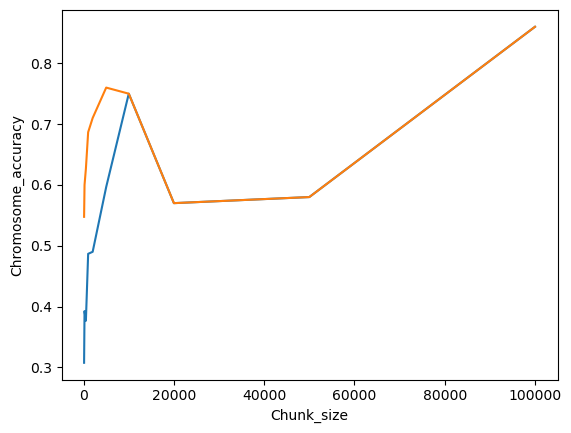

In [22]:
import seaborn as sns 

sns.lineplot(data = df,
             x = "Chunk_size",
             y = "Chromosome_accuracy",
            )


sns.lineplot(data = df,
             x = "Chunk_size",
             y = "Genome_accuracy",
            )
